In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import koopomics as ko
import pandas as pd
import torch.nn as nn

In [2]:
# Load Dataset
pregnancy_df = pd.read_csv('/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/input_data/pregnancy/pregnancy_interpolated_264M_robust_minmax_scaled_outlrem_uniform.csv')

condition_id = 'Condition'
time_id = 'Gestational age (GA)/weeks'
replicate_id = 'Subject ID'
feature_list = pregnancy_df.columns[7:]
num_features = len(feature_list)

train_set_df = pregnancy_df[pregnancy_df['Cohort'] == 'Discovery'].copy()
test_set_df = pregnancy_df[pregnancy_df['Cohort'] == 'Validation (Test Set 1)'].copy()
train_dataloader = ko.OmicsDataloader(train_set_df, feature_list, replicate_id, time_id, 
                                      batch_size=5, max_Ksteps = 10)
test_dataloader = ko.OmicsDataloader(test_set_df, feature_list, replicate_id, time_id, 
                                     batch_size=5, max_Ksteps = 10)


In [3]:
# Load Model
embedding_model = ko.FF_AE([150,200,200,200,200,200,30], [30,200,200,200,200,200,150],E_dropout_rates= [0.3,0,0,0,0,0,0])
#operator_model = ko.LinearizingKoop(linearizer=ko.FFLinearizer([3,1000,10], [10,1000,3], linE_dropout_rates=[0,0,0]), koop=ko.InvKoop(latent_dim=10, reg='skewsym'))
operator_model = ko.InvKoop(latent_dim=30, reg='skewsym')
TestingKoop = ko.KoopmanModel(embedding=embedding_model, operator=operator_model)


30.0 % dropout for input layer initialized.
Skew-Symmetric Matrix initialized with 435 trainable parameters.
Skew-Symmetric Matrix initialized with 435 trainable parameters.
Model loaded with:
FF_AE module
InvKoop module
An invertible Koop


In [25]:
# Load Model Parameters
param_path = '/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/Developing/TestingKoop50M_augm.pth'
TestingKoop.load_state_dict(torch.load(param_path))

<All keys matched successfully>

In [13]:
# Inspect Single Predictions
input_df = pregnancy_df.copy()
metabolite_names = input_df.columns[7:]
# df must have feature from column 6 onward and metadata until column 6.
#input_df[metabolite_names] =  input_df[metabolite_names].sub(average_row_mean, axis=0)

input_tensor = torch.tensor(input_df.iloc[:3, 7:].values, dtype=torch.float32).flatten()
print(input_tensor)

tensor([ 4.0788,  6.7204,  0.8375,  3.0691,  1.8112,  2.1298,  3.1853,  1.2465,
         1.1546,  1.3087,  4.6356,  4.5683,  2.3896,  3.5120,  3.8737,  3.5870,
        10.4226,  1.9246,  2.8194,  0.5428,  1.5824,  3.1041,  3.4065,  0.3207,
         9.8846,  4.7530,  2.4803,  3.5616,  2.7470,  3.7159,  3.8388,  5.2040,
         5.0908,  1.5047,  7.9149,  2.7452,  3.6589,  2.4491,  4.6480,  2.0172,
         1.9646,  5.1582,  4.2448,  2.0093,  3.2382,  3.8201,  3.5969,  3.3397,
         1.6447,  4.0331,  4.8695,  6.3175,  1.1166,  2.9574,  2.3481,  2.9076,
         2.8170,  0.9887,  1.0701,  1.1102,  4.5383,  4.3549,  1.8470,  3.3765,
         3.9280,  3.0004, 10.7810,  2.5806,  3.1772,  0.8955,  1.6923,  3.1228,
         4.2888,  0.2209,  9.9370,  5.2199,  2.2753,  3.5049,  2.9899,  3.9684,
         4.1105,  5.6693,  4.9046,  1.2851,  8.4402,  2.5636,  3.2450,  2.9342,
         4.8661,  2.8483,  1.9447,  5.1212,  3.9212,  1.8332,  3.7104,  4.0478,
         3.1104,  2.4323,  1.3922,  3.91

In [14]:
pregnancy_df.iloc[:3,7:]

,1-Stearoyl-sn-glycero-3-phosphocholine,16-Hydroxypalmitic acid,"17,18-EpETE",17alpha-Hydroxyprogesterone,2-Ethyl-2-Hydroxybutyric acid,2-Linoleoylglycerol,"3,4-Dimethylbenzaldehyde",3-Acetoxypyridine,"5-Pregnane-3,17-diol-20-one 3-sulfate",7-Methylguanine,...,THDOC,Pregnenolone sulfate,Progesterone,Reserpine,SM(d32:1),Sphinganine 1-phosphate,Traumatic Acid,alpha-Linolenic acid,d-LIMONENE,gamma-Glutamylleucine
0,4.078802,6.720404,0.837500,3.069125,1.811161,2.129807,3.185257,1.246459,1.154569,1.308671,...,1.964582,5.158214,4.244810,2.009253,3.238224,3.820112,3.596947,3.339663,1.644679,4.033064
1,4.869533,6.317517,1.116635,2.957377,2.348065,2.907635,2.816964,0.988701,1.070059,1.110157,...,1.944697,5.121172,3.921224,1.833157,3.710439,4.047770,3.110371,2.432307,1.392197,3.917097
2,4.719806,5.477149,1.421002,2.789249,2.636431,3.970924,1.729101,0.677508,1.566671,1.011459,...,1.844474,5.573536,3.919135,1.953809,3.969547,4.336034,3.090917,1.717875,3.542692,4.072933


In [15]:
TestingKoop(input_tensor, fwd=1)

([],
 [tensor([ 3.6746,  6.0286,  2.9748,  2.8638,  1.9174,  2.6434,  2.6356,  1.6506,
           2.0646,  1.9766,  2.9157,  6.2277,  2.7720,  2.5605,  4.3058,  3.6382,
          10.3900,  3.3590,  3.7948,  2.6374,  2.8790,  2.3159,  5.1896,  2.5068,
          10.1086,  5.1300,  2.9233,  4.2416,  2.5744,  2.3715,  2.0821,  4.6090,
           4.7989,  1.8917,  8.1807,  2.2267,  3.0404,  1.8292,  5.2765,  2.2512,
           2.1248,  6.3008,  5.3037,  2.6009,  3.5325,  3.2692,  3.0326,  3.1850,
           3.3788,  4.3979,  3.7008,  5.9828,  3.0452,  2.9702,  1.8548,  2.6233,
           2.6686,  1.7400,  2.1430,  2.0740,  2.8473,  6.3188,  2.7359,  2.6332,
           4.2859,  3.5759, 10.3605,  3.3331,  3.7635,  2.7108,  2.9605,  2.2421,
           5.3604,  2.6128, 10.1553,  5.1380,  2.9209,  4.2219,  2.5297,  2.3256,
           2.0180,  4.5080,  4.7678,  1.9688,  8.1810,  2.2137,  3.0583,  1.7716,
           5.3180,  2.1985,  2.2266,  6.3756,  5.4066,  2.5837,  3.5601,  3.2486,
           

In [4]:
model = ko.NaiveMeanPredictor()
model.fit(train_set_df, feature_list)
feature_errors = model.calculate_reference_values(train_dataloader, test_dataloader, max_Kstep=15, featurewise=True, normalize=False)
feature_errors

({'fwd_feature_errors': {0: 0.006066753373791774,
   1: 0.0170554885652867,
   2: 0.010437339129324149,
   3: 0.005475950627320951,
   4: 0.019378138531465083,
   5: 0.01709380503113304,
   6: 0.015096588065110458,
   7: 0.004435086109242548,
   8: 0.016695782866251344,
   9: 0.017121563085432476,
   10: 0.005323014868918108,
   11: 0.020206455319809417,
   12: 0.017862044686141113,
   13: 0.007566205993740974,
   14: 0.007272595338630102,
   15: 0.011082149122375994,
   16: 0.012564469816667648,
   17: 0.013806663365297329,
   18: 0.01405655575702743,
   19: 0.0013175307655690935,
   20: 0.010782061356439953,
   21: 0.004621398487415718,
   22: 0.018412055701871093,
   23: 0.008738527141637557,
   24: 0.012780517550224128,
   25: 0.005625016313570086,
   26: 0.006275213361125982,
   27: 0.020728585878775144,
   28: 0.02110767741299545,
   29: 0.014508759289553079,
   30: 0.005125831565843934,
   31: 0.009119920233691422,
   32: 0.020428874610418764,
   33: 0.01923456537454816,
   34: 

In [5]:
print('Train Set Error Naive Model')

print(feature_errors[0]['total_fwd_loss'])
print(feature_errors[0]['total_bwd_loss'])

print('Test Set Error Naive Model')

print(feature_errors[1]['total_fwd_loss'])
print(feature_errors[1]['total_bwd_loss'])


Train Set Error Naive Model
tensor(0.0119)
tensor(0.0119)
Test Set Error Naive Model
tensor(0.0134)
tensor(0.0134)


In [85]:
(0.4423-0.376)/0.4423

0.1498982591001583

In [29]:
loss_dict = ko.test(TestingKoop, test_dataloader, max_Kstep=15, disable_tempcons=False)

In [35]:
ko.compute_prediction_errors(TestingKoop, test_dataloader, max_Kstep=15, featurewise=True)

{'fwd_feature_errors': {0: 0.24201165134476701,
  1: 0.20627824679333542,
  2: 0.3728647324046654,
  3: 0.19326391030498863,
  4: 0.22430859241657417,
  5: 0.6636612245148591,
  6: 0.49677698878729915,
  7: 0.23354323223492693,
  8: 0.28611086132361946,
  9: 0.2662866301428308,
  10: 0.42204931371361065,
  11: 0.15950749005324572,
  12: 0.16916039424483145,
  13: 0.15976157909616703,
  14: 0.30286686053311335,
  15: 0.32010048451891904,
  16: 0.2467917588675033,
  17: 0.49116685247286074,
  18: 0.3435243566032468,
  19: 0.6672251068411488,
  20: 0.4200227679177638,
  21: 0.35681108739013795,
  22: 0.1773105155230938,
  23: 0.4646683270584772,
  24: 0.2617135297847624,
  25: 0.18356589757269623,
  26: 0.1948791320833455,
  27: 0.19814752241089892,
  28: 0.3323058618448913,
  29: 0.28769336146077945},
 'bwd_feature_errors': {0: 0.19661265104864695,
  1: 0.07913403603797085,
  2: 0.48887425612572394,
  3: 0.1535072981303706,
  4: 0.19836844347073887,
  5: 1.404499434814328,
  6: 0.4868145

In [30]:
(np.mean([0.2414, 0.2521]) - np.mean([0.1690, 0.1705]))/np.mean([0.2414, 0.2521])

0.31205673758865243

In [31]:
loss_dict

{'test_fwd_loss': tensor(0.3148),
 'test_bwd_loss': tensor(0.3863),
 'test_temp_cons_loss': tensor(0.2347),
 'test_inv_cons_loss': 0.9504705823492259,
 'dict_fwd_step_loss': {1: 0.40392707526049715,
  2: 0.4003765665470286,
  3: 0.379787220996111,
  4: 0.37015724784516274,
  5: 0.38111362566656254,
  6: 0.35479409469568984,
  7: 0.344532643860959,
  8: 0.35334560552493055,
  9: 0.27983448091656604,
  10: 0.26696901011498686,
  11: 0.2538208044431311,
  12: 0.2531249947211844,
  13: 0.23928976494898188,
  14: 0.2158168631189681,
  15: 0.22536397004064093},
 'dict_fwd_step_tempcons_loss': {(2, 1): 0.11555435270705122,
  (3, 1): 0.11522272023114752,
  (3, 2): 0.0989124465813028,
  (4, 1): 0.14054191271041303,
  (4, 2): 0.11607282545338286,
  (4, 3): 0.1360148516424159,
  (5, 1): 0.10818849171095705,
  (5, 2): 0.09555121043578108,
  (5, 3): 0.11121430105351388,
  (5, 4): 0.12188308717722589,
  (6, 1): 0.11261250950554584,
  (6, 2): 0.08564266174080525,
  (6, 3): 0.10404066091522257,
  (6, 

In [26]:
bwdmatrix, fwdmatrix = TestingKoop.kmatrix()
bwdM = bwdmatrix.detach()
fwdM = fwdmatrix.detach()
fwdinv = np.linalg.inv(fwdM)

In [27]:
B, F = bwdM, fwdM


K = F.shape[-1]
loss_inv_cons = 0
for k in range(1,K+1):
    Fs1 = F[:,:k]
    Bs1 = B[:k,:]
    Fs2 = F[:k,:]
    Bs2 = B[:,:k]

    Ik = torch.eye(k).float()#.to(device)

    loss_inv_cons += (torch.sum((torch.matmul(Bs1, Fs1) - Ik)**2) + \
                         torch.sum((torch.matmul(Fs2, Bs2) - Ik)**2) ) / (2.0*k)

loss_inv_cons

tensor(11611.9414)

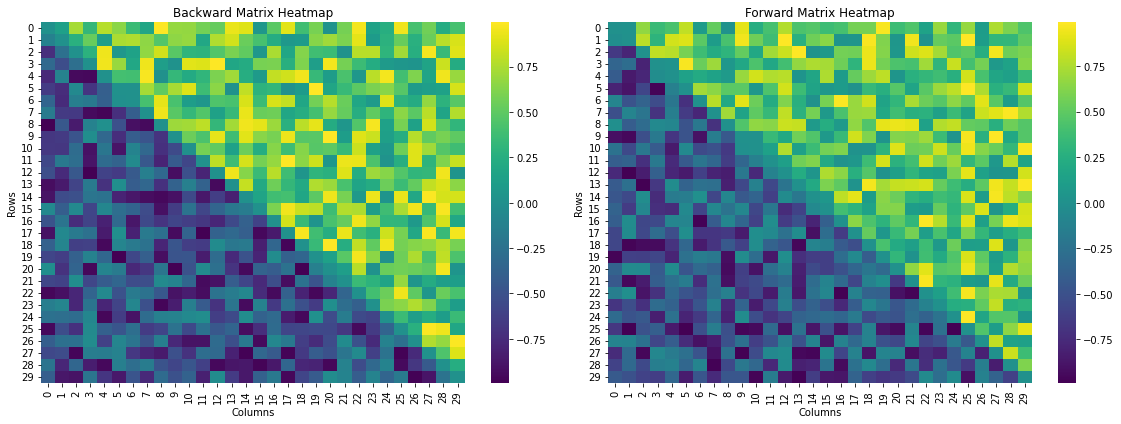

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# First heatmap (for bwdM)
sns.heatmap(bwdM, annot=False, fmt=".2f", cmap='viridis', ax=ax1)
ax1.set_title('Backward Matrix Heatmap')
ax1.set_xlabel('Columns')
ax1.set_ylabel('Rows')

# Second heatmap (for fwdM)
sns.heatmap(fwdM, annot=False, fmt=".2f", cmap='viridis', ax=ax2)
ax2.set_title('Forward Matrix Heatmap')
ax2.set_xlabel('Columns')
ax2.set_ylabel('Rows')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the subplots
plt.show()


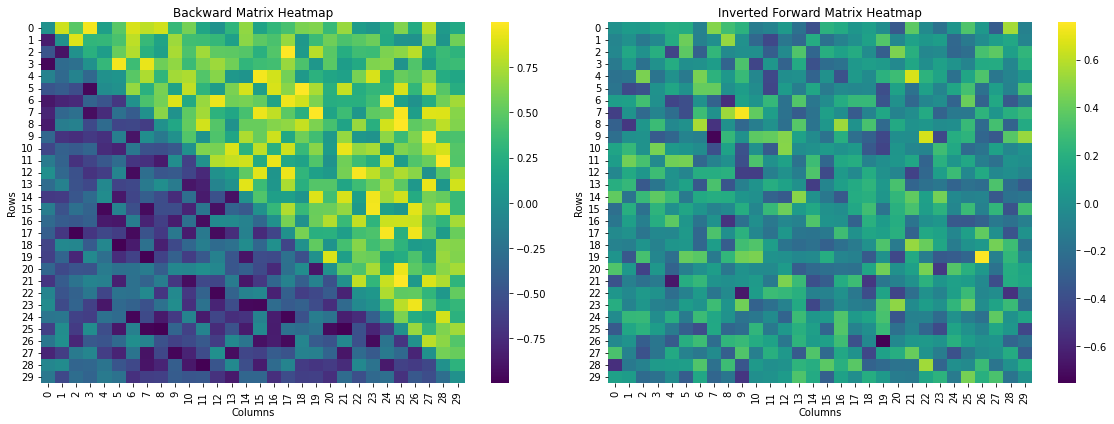

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# First heatmap (for bwdM)
sns.heatmap(bwdM, annot=False, fmt=".2f", cmap='viridis', ax=ax1)
ax1.set_title('Backward Matrix Heatmap')
ax1.set_xlabel('Columns')
ax1.set_ylabel('Rows')

# Second heatmap (for fwdM)
sns.heatmap(fwdinv, annot=False, fmt=".2f", cmap='viridis', ax=ax2)
ax2.set_title('Inverted Forward Matrix Heatmap')
ax2.set_xlabel('Columns')
ax2.set_ylabel('Rows')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the subplots
plt.show()


In [29]:
eigenvalues, eigenvectors = np.linalg.eig(fwdM)
print("FWD Matrix:")
print(fwdM)
print("\nEigenvalues:")
print(list(eigenvalues))
print("\nEigenvectors:")
print(list(eigenvectors))

FWD Matrix:
tensor([[ 0.0000,  0.0182,  0.6645,  0.3529,  0.4250,  0.7988,  0.0900,  0.5156,
          0.0088,  0.9057,  0.2415,  0.4085,  0.7646,  0.4305,  0.4560,  0.3662,
          0.4093,  0.5733,  0.5750,  0.9692,  0.3654,  0.4449,  0.1508,  0.6842,
          0.3086,  0.6752,  0.0973,  0.7434,  0.6025,  0.4362],
        [-0.0182,  0.0000,  0.7874,  0.2909,  0.8550,  0.8823,  0.4862,  0.0941,
          0.4138,  0.9495,  0.5558,  0.3750,  0.9892,  0.2681,  0.5494,  0.6468,
          0.0364,  0.0439,  0.9700,  0.6136,  0.0490,  0.9440,  0.0144,  0.5216,
          0.4815,  0.9865,  0.1027,  0.3095,  0.3229,  0.5019],
        [-0.6645, -0.7874,  0.0000,  0.8017,  0.7728,  0.5805,  0.3703,  0.2205,
          0.2966,  0.5102,  0.1952,  0.7155,  0.8273,  0.9823,  0.0300,  0.0750,
          0.5666,  0.5617,  0.9324,  0.6193,  0.0574,  0.8398,  0.8836,  0.7157,
          0.4472,  0.4921,  0.2522,  0.9550,  0.5542,  0.5961],
        [-0.3529, -0.2909, -0.8017,  0.0000,  0.0254,  0.9710,  0.5

In [41]:
eigenvalues, eigenvectors = np.linalg.eig(bwdM)
print("BWD Matrix:")
print(bwdM)
print("\nEigenvalues:")
print(list(eigenvalues))
print("\nEigenvectors:")
print(list(eigenvectors))

BWD Matrix:
tensor([[ 0.0000, -0.1396, -0.6372,  0.2643, -0.3561,  0.3594, -0.0944, -0.2916,
         -0.3336,  0.0647],
        [ 0.1396,  0.0000, -0.2647,  0.0668,  0.5213, -0.5294, -0.0936, -0.2228,
         -0.4216, -0.2535],
        [ 0.6372,  0.2647,  0.0000, -0.4228, -0.1486,  0.1220, -0.4312,  0.0433,
         -0.0964, -0.1844],
        [-0.2643, -0.0668,  0.4228,  0.0000, -0.3046, -0.1122, -0.4982,  0.1288,
         -0.4283, -0.1289],
        [ 0.3561, -0.5213,  0.1486,  0.3046,  0.0000,  0.1404,  0.0577,  0.3222,
          0.0049, -0.3562],
        [-0.3594,  0.5294, -0.1220,  0.1122, -0.1404,  0.0000,  0.0453,  0.0457,
         -0.1741, -0.4076],
        [ 0.0944,  0.0936,  0.4312,  0.4982, -0.0577, -0.0453,  0.0000, -0.4108,
          0.1439, -0.3203],
        [ 0.2916,  0.2228, -0.0433, -0.1288, -0.3222, -0.0457,  0.4108,  0.0000,
          0.0191, -0.3328],
        [ 0.3336,  0.4216,  0.0964,  0.4283, -0.0049,  0.1741, -0.1439, -0.0191,
          0.0000,  0.4211],
       